## Problem 4: What is the closest shopping center from your home / work? (5 points)

In the last problem you should find out the closest shopping center from two different locations a) your home and b) work place. 

**Steps**:

 - Create a txt-file called `activity_locations.txt` (use same formatting as in Problem 1) with two columns:
    - `id`: unique id for each row
    - `addr`:  address of your work and home (or any two addresses in the Helsinki Region.)
    
Save the text file into this repository.
    
 - Read those addresses using pandas and geocode the addresses.
 - Find out the nearest shopping center to these points using Shapely `nearest_points`.
 - Print out the name of the shopping center that is nearest to a) home and b) work. For example: `Shopping center closest to home: REDI`.

In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import CRS
from shapely.ops import nearest_points

# read in input files
data = pd.read_csv("activity_locations.txt", sep=";")
data

,id,name,addr
0,0,Bain & Company,"Aleksanterinkatu 30-34, 00100 Helsinki, Finland"
1,1,Vartiokylä Church,"Kiviportintie 5, 00950 Helsinki, Finland"


In [2]:
# Geocode activity locations
geo = gpd.tools.geocode(data["addr"], provider="nominatim", user_agent="autogis_xx", timeout=4)
geo

,geometry,address
0,POINT (24.95069 60.16884),"Bain & Company, 30-34, Aleksanterinkatu, Kesku..."
1,POINT (25.10160 60.21981),"Vartiokylän kirkko, 5, Kiviportintie, Vartioha..."


In [3]:
# Check coordinate reference system information (re-project/define if needed)
if geo.crs:
    print(f"The existing CRS of geo is {geo.crs}")
    geo = geo.to_crs(epsg=3879)
    print(f"The reprojected CRS of geo is {geo.crs}")
else:
    geo.crs = CRS.from_epsg(3879).to_wkt()
    print(f"geo didn't have a CRS so it is now projected to {geo.crs}")

The existing CRS of geo is EPSG:4326
The reprojected CRS of geo is epsg:3879


In [4]:
# Join the tables
geodata = geo.join(data)
geodata = geodata[["id", "name", "geometry"]]
geodata

,id,name,geometry
0,0,Bain & Company,POINT (25497262.268 6672885.179)
1,1,Vartiokylä Church,POINT (25505631.728 6678566.881)


In [5]:
# Read in the shopping center
shop_centers = gpd.read_file("shopping_centers.shp")
shop_centers

,address,id,name,addr,geometry
0,"Kauppakeskus Itis, 1-7, Itäkatu, Itäkeskus, Va...",0,Itis,"Itäkatu 1-7, 00930 Helsinki, Finland",POINT (25504598.602 6677662.109)
1,"Salaattiasema, 14-20, Mannerheimintie, Keskust...",1,Forum,"Mannerheimintie 14?20, 00100 Helsinki, Finland",POINT (25496573.542 6672878.360)
2,"Iso Omena, 11, Piispansilta, Matinkylä, Suur-M...",2,Iso-omena,"Piispansilta 11, 02230 Espoo, Finland",POINT (25485470.196 6672071.413)
3,"Lasten kappeli Arkki, 3-9, Leppävaarankatu, Sä...",3,Sello,"Leppävaarankatu 3-9, 02600 Espoo, Finland",POINT (25489491.076 6678322.265)
4,"Stockmann, 3, Vantaanportinkatu, Vantaanportti...",4,Jumbo,"Vantaanportinkatu 3, 01510 Vantaa, Finland",POINT (25497943.932 6686656.982)
5,"Silta, 5, Hermannin rantatie, Verkkosaari, Kal...",5,REDI,"Hermannin rantatie 5, 00580 Helsinki, Finland",POINT (25498837.156 6674909.983)
6,"Viikki, Koillinen suurpiiri, Helsinki, Helsing...",6,Tripla,"00520 Helsinki, Finland",POINT (25501100.650 6678519.536)


In [6]:
def get_nearest_values(row, other_gdf, point_col="geometry", value_col="geometry"):
    """
    Find the nearest point and return the corresponding value from specified value column.
    
    Parameters
    ----------
    row : GeoDataFrame
        Row from which values will be retrieved
    other_gdf : GeoDataFrame
        GeoDataFrame with points to calculate nearest neighbor
    point_col : str
        Name of the column containing the points
    value_col : str
        Name of the column containing the value of the nearest neighbor
        
    Return
    ------
    nearest_value : int
        Value from the nearest neighbor
    """
    # Create an union of the other GeoDataFrame's value
    other_points = other_gdf["geometry"].unary_union
    
    # Find the nearest points
    nearest_geoms = nearest_points(row[point_col], other_points)
    
    # Get corresponding values from other_gdf
    nearest_data = other_gdf.loc[other_gdf["geometry"] == nearest_geoms[1]]
    
    # Extract needed value
    nearest_val = nearest_data[value_col].values[0]
    
    return nearest_val

In [7]:
# Find out the nearest shopping center
geodata["nearest_loc"] = geodata.apply(lambda row: get_nearest_values(row, shop_centers, value_col="name"), axis=1)
geodata

,id,name,geometry,nearest_loc
0,0,Bain & Company,POINT (25497262.268 6672885.179),Forum
1,1,Vartiokylä Church,POINT (25505631.728 6678566.881),Itis


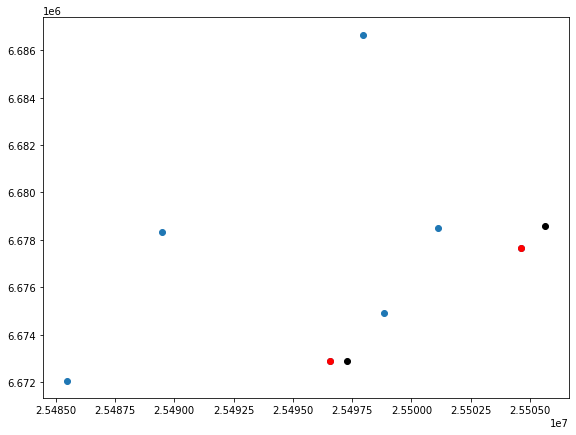

In [8]:
# Plot the points
fig, ax = plt.subplots(figsize=(10, 7))

shop_centers.plot(ax=ax)
near = shop_centers[(shop_centers["name"] == geodata.iloc[0, 3]) | 
                    (shop_centers["name"] == geodata.iloc[1, 3])]
near.plot(ax=ax, color="red")
geodata.plot(ax=ax, color="black");

In [9]:
# Print out the name of the shopping centers and activity locations
print(f"Shopping center closest to {geodata.iloc[0, 1]} is: {geodata.iloc[0, 3]}.")
print(f"Shopping center closest to {geodata.iloc[1, 1]} is: {geodata.iloc[1, 3]}.")

Shopping center closest to Bain & Company is: Forum.
Shopping center closest to Vartiokylä Church is: Itis.


Can you think of other application cases for the nearest neighbour analysis?

In [10]:
def calc_dist(row, dest_geom, src_col="geometry", target_col="distance"):
    """
    Calculates the distance between Point geometries.

    Parameters
    ----------
    row : GeoDataFrame
        Row from which values will be retrieved
    dest_geom : shapely.Point
       A single Shapely Point geometry to which the distances will be calculated to.
    src_col : str
       A name of the column that has the Shapely Point objects from where the distances will be calculated from.
    target_col : str
       A name of the target column where the result will be stored.

    Return
    -------
        Distance in kilometers that will be stored in 'target_col'.
    """

    # Calculate the distances
    dist = row[src_col].distance(dest_geom)

    # Convert into kilometers
    dist_km = dist / 1000

    # Assign the distance to the original data
    row[target_col] = dist_km
    return row

In [11]:
# Calculate the distance
temp = shop_centers.apply(calc_dist, dest_geom=geodata.iloc[0, 2], target_col="dist_to_Bain&Co", axis=1)
temp = temp.apply(calc_dist, dest_geom=geodata.iloc[1, 2], target_col="dist_to_Church", axis=1)
temp

,address,id,name,addr,geometry,dist_to_Bain&Co,dist_to_Church
0,"Kauppakeskus Itis, 1-7, Itäkatu, Itäkeskus, Va...",0,Itis,"Itäkatu 1-7, 00930 Helsinki, Finland",POINT (25504598.602 6677662.109),8.754476,1.373304
1,"Salaattiasema, 14-20, Mannerheimintie, Keskust...",1,Forum,"Mannerheimintie 14?20, 00100 Helsinki, Finland",POINT (25496573.542 6672878.360),0.688759,10.696261
2,"Iso Omena, 11, Piispansilta, Matinkylä, Suur-M...",2,Iso-omena,"Piispansilta 11, 02230 Espoo, Finland",POINT (25485470.196 6672071.413),11.820118,21.182032
3,"Lasten kappeli Arkki, 3-9, Leppävaarankatu, Sä...",3,Sello,"Leppävaarankatu 3-9, 02600 Espoo, Finland",POINT (25489491.076 6678322.265),9.484373,16.142506
4,"Stockmann, 3, Vantaanportinkatu, Vantaanportti...",4,Jumbo,"Vantaanportinkatu 3, 01510 Vantaa, Finland",POINT (25497943.932 6686656.982),13.788663,11.160284
5,"Silta, 5, Hermannin rantatie, Verkkosaari, Kal...",5,REDI,"Hermannin rantatie 5, 00580 Helsinki, Finland",POINT (25498837.156 6674909.983),2.565171,7.716159
6,"Viikki, Koillinen suurpiiri, Helsinki, Helsing...",6,Tripla,"00520 Helsinki, Finland",POINT (25501100.650 6678519.536),6.817562,4.531326


In [12]:
# Add distance to geodata
geodata["distance"] = None
geodata.iloc[0, 4] = temp["dist_to_Bain&Co"].min()
geodata.iloc[1, 4] = temp["dist_to_Church"].min()

In [13]:
# Print out the name of the shopping centers and activity locations with the distance between them
print(f"Shopping center closest to {geodata.iloc[0, 1]} is: {geodata.iloc[0, 3]}, with a distance of: {geodata.iloc[0, 4]:.2f} m.")
print(f"Shopping center closest to {geodata.iloc[1, 1]} is: {geodata.iloc[1, 3]}, with a distance of: {geodata.iloc[1, 4]:.2f} m.")

Shopping center closest to Bain & Company is: Forum, with a distance of: 0.69 m.
Shopping center closest to Vartiokylä Church is: Itis, with a distance of: 1.37 m.
